In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from numpy.random import uniform, lognormal, normal
import matplotlib.pyplot as plt 
from astropy.modeling.models import Sersic2D


In [53]:
def make_galaxy_parameters(n_images=1000, n_gal_per_image=2,
                         img_size=(64,64), seed = 12345, plot = True):
    n_gals = (n_images, n_gal_per_image)
    print(n_gals)
    np.random.seed(seed)
    params = dict(
        amplitude = lognormal(0, 0.1, size=n_gals),
        r_eff = lognormal(2, 0.1, size=n_gals),
        n = lognormal(0.5, 0.2, size=n_gals),
        #ellip = uniform(0.0, 0.8, size=n_gals),
        x_0 = normal(0.5, 0.1, size=n_gals) * img_size[0],
        y_0 = normal(0.5, 0.1, size=n_gals) * img_size[1],
        theta = uniform(0.0, np.pi, size=n_gals)
    )
    if plot:
        fig, axarr = plt.subplots(2, 4, figsize=(15, 8))
        for ax, (par, values) in zip(axarr.flat, params.items()):
            ax.hist(values, histtype='step')
            ax.set_xlabel(par)
        axarr.flat[-1].axis('off')
    return params

(1000, 2)


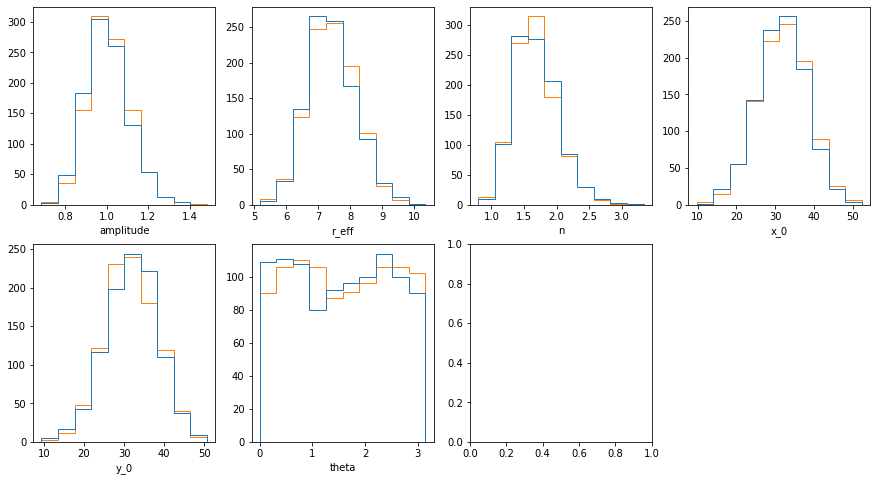

In [54]:
make_galaxy_parameters();

In [55]:
def make_blended_gals(params, img_size=(64, 64)):
    x, y = np.mgrid[:img_size[1], :img_size[0]]
    shape = params['n'].shape
    print(shape)
    components = np.zeros(shape + img_size[::-1])
    blended = np.zeros(shape[:1] + img_size[::-1])
    for img_idx in range(shape[0]):
        for gal_idx in range(shape[1]):
            par = {p: x[img_idx, gal_idx] for p, x in params.items()}
            mod = Sersic2D(**par)(y, x)
            components[img_idx, gal_idx] = mod
            blended[img_idx] += mod
    return components, blended

In [56]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)


In [57]:
def asinh_scale(x, a=0.1, inverse=False):
    # This is a common way of scaling astronomical images
    # so that inner and outer regions of galaxies can be seen
    return np.arcsinh(x / a) / np.arcsinh(1 / a)

In [58]:

ngal = 1000
ncomp = 2

params = make_galaxy_parameters(ngal, ncomp, plot=False)

components, blended = make_blended_gals(params)

#blended = add_noise(blended)

components = asinh_scale(components)
blended = asinh_scale(blended)


(1000, 2)
(1000, 2)


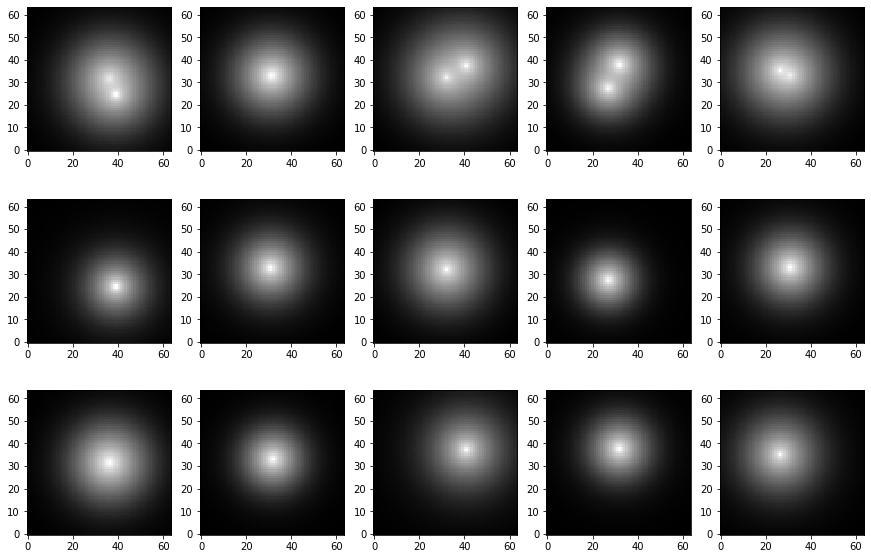

In [59]:
fig, ax = plt.subplots(ncomp + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blended[i], cmap='gray', origin='lower', interpolation='nearest')
    for j in range(ncomp):
        ax[j + 1, i].imshow(components[i, j], cmap='gray', origin='lower', interpolation='nearest') 

In [60]:
#print(np.shape(blended))
#print(np.shape(components))

#sequential_components = components.reshape(,64,64)

#print(np.shape(sequential_components))
#dataset = np.concatenate((blended, sequential_components))
#print(dataset)
print(np.shape(components)) 
print(np.shape(blended)) 

(1000, 2, 64, 64)
(1000, 64, 64)


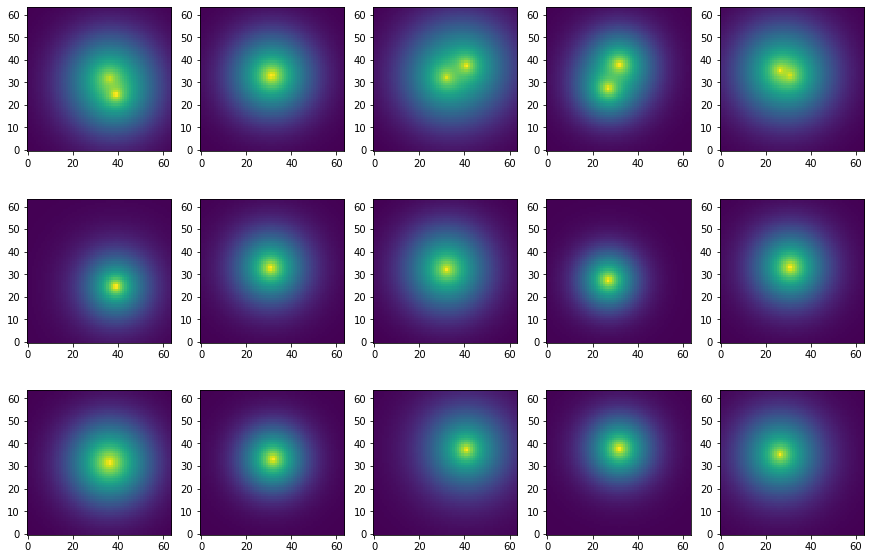

In [61]:
sequential_components = components.reshape(2000,64,64)
fig, ax = plt.subplots(ncomp + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blended[i], origin='lower', interpolation='nearest')
    ax[1, i].imshow(sequential_components[2*i], origin='lower', interpolation='nearest')
    ax[2, i].imshow(sequential_components[2*i + 1], origin='lower', interpolation='nearest')

In [63]:
np.save("C:\\Datasets\\blends.npy", blended)
np.save("C:\\Datasets\\components.npy", components)